# Clustering Social Media Data

# Importing and cleaning the data

In [1604]:
import numpy as np
import pandas as pd
import pickle
from os import path as Path

In [1643]:
s3_data_dir="s3://ds-rg271/data"
s3_model_dir="s3://ds-rg271/models"

input_data_uri = Path.join(s3_data_dir,"labelled/mebank_tweets_1_year_labelled.csv")
print(input_data_uri)

s3://ds-rg271/data/labelled/mebank_tweets_1_year_labelled.csv


In [1606]:
input_data=pd.read_csv(input_data_uri)

In [1607]:
print(type(input_data))
input_data.tail()

<class 'pandas.core.frame.DataFrame'>


,Unnamed: 0,date,content,complaint,topic,content_type,user,url
892,892,2020-08-27 01:57:06+00:00,"@mebank Still crap. And yes, I've checked MY ...",1.0,Problem/System Down,twitter/mention,EightTwo5,https://twitter.com/EightTwo5/status/129880168...
893,893,2020-12-26 02:24:48+00:00,@mebank I understand that this must be a busy ...,1.0,Problem/Customer Service,twitter/mention,MarkTayar,https://twitter.com/MarkTayar/status/134265758...
894,894,2020-09-11 00:09:35+00:00,I am paying more on rent than on a 100% LVR pr...,0.0,NaN,twitter/mention,OnceANerd,https://twitter.com/OnceANerd/status/130421044...
895,895,2020-12-24 06:35:28+00:00,@mebank @DamienFarrugia Didn't get Mum a Chris...,1.0,Problem/Others,twitter/mention,LongyLonghorn,https://twitter.com/LongyLonghorn/status/13419...
896,896,2020-09-21 02:30:03+00:00,"ME Bank looks to e-signatures, digital loan pr...",0.0,NaN,twitter/mention,MrtgBusiness,https://twitter.com/MrtgBusiness/status/130786...


In [1608]:
import datetime
import re

for i, date_str in enumerate(input_data['date']):
	date_str=re.sub('\+00:00', '', date_str)
	input_data.loc[i,'date']=datetime.datetime.strptime(date_str,'%Y-%m-%d %H:%M:%S')


In [1609]:
# sorting data based on date
input_data_sorted=input_data.sort_values(by=['date'],ignore_index=True).reset_index(drop=True)
input_data_sorted.shape

(897, 8)

In [1610]:
# removing 0.5 and -1 labels 
input_data_01=input_data_sorted[input_data_sorted.complaint.isin([0, 1])].reset_index(drop=True)
input_data_01.shape

(862, 8)

In [1611]:
input_data_01.tail()

,Unnamed: 0,date,content,complaint,topic,content_type,user,url
857,550,2021-07-22 10:15:06,"Congrats to Ella Van De Velde Fidock, Register...",0.0,NaN,twitter/mention,qnmuofficial,https://twitter.com/qnmuofficial/status/141815...
858,868,2021-07-22 23:39:22,@mebank How do you justify taking 3 weeks to g...,1.0,Problem/Customer Service,twitter/mention,heathwilder,https://twitter.com/heathwilder/status/1418355...
859,325,2021-07-23 13:21:12,@mebank So... do you have a timeframe when is ...,0.0,Inquiry,twitter/mention,spikeuk1982,https://twitter.com/spikeuk1982/status/1418561...
860,625,2021-07-24 01:09:02,So @mebank made me come all the way to police ...,1.0,Problem/Others,twitter/mention,TheDadhiwala,https://twitter.com/TheDadhiwala/status/141873...
861,573,2021-07-25 09:22:13,Making beautiful banking and helping Australi...,0.0,NaN,twitter/mention,sandybeech4,https://twitter.com/sandybeech4/status/1419226...


In [1616]:
# Ensure all labels are the same by making them lower case and stripping trailing whitespace
input_data_01["topic"] = input_data_01["topic"].str.lower().str.strip()

# Ensure complaint is integer
input_data_01["complaint"] = input_data_01["complaint"].astype(int)

# Fix missed problem - other
input_data_01.loc[input_data_01["topic"] == "problem - other", "topic"] = "problem/others"

In [1617]:
input_data_01.tail()

,Unnamed: 0,date,content,complaint,topic,content_type,user,url
857,550,2021-07-22 10:15:06,"Congrats to Ella Van De Velde Fidock, Register...",0,NaN,twitter/mention,qnmuofficial,https://twitter.com/qnmuofficial/status/141815...
858,868,2021-07-22 23:39:22,@mebank How do you justify taking 3 weeks to g...,1,problem/customer service,twitter/mention,heathwilder,https://twitter.com/heathwilder/status/1418355...
859,325,2021-07-23 13:21:12,@mebank So... do you have a timeframe when is ...,0,inquiry,twitter/mention,spikeuk1982,https://twitter.com/spikeuk1982/status/1418561...
860,625,2021-07-24 01:09:02,So @mebank made me come all the way to police ...,1,problem/others,twitter/mention,TheDadhiwala,https://twitter.com/TheDadhiwala/status/141873...
861,573,2021-07-25 09:22:13,Making beautiful banking and helping Australi...,0,NaN,twitter/mention,sandybeech4,https://twitter.com/sandybeech4/status/1419226...


In [1621]:
input_data_01.to_csv("../data/mebank_tweets_1_year_clean.csv", index=False)
input_data_01.to_csv(f"{s3_data_dir}/labelled/mebank_tweets_1_year_cleaned.csv", index=False)

Cleaning and preprocessing the input text

In [ ]:
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'mebank','um','umm','ummm','hi','hello','hey','heyyyyy','fyi'])

In [ ]:
#installing tweet-preprocessor
!pip install tweet-preprocessor

In [1623]:
import preprocessor as tweet_preprocessor
#forming a separate feature for cleaned tweets

def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
	'''
		Preprocess a string.

		parameters:
		- param text: string - name of column containing text
		- param lst_stopwords: list - list of stopwords to remove
		- param flg_stemm: bool - whether stemming is to be applied
		- param flg_lemm: bool - whether lemmitisation is to be applied
		returns:
		- cleaned text
	'''

	text=tweet_preprocessor.clean(text)

	# Remove mentions
	#text = re.sub(r'/^(?!.*\bRT\b)(?:.+\s)?@\w+/i', '', text)
	#text = re.sub('@', '', text)
	
	# Remove Emails
	#text = re.sub('\S*@\S*\s?', '', text)

	# Remove links
	#text = re.sub('http\S*', '', text)

	# Remove hashtags
	# #text = re.sub('#\S*', '', text)
	#text = re.sub('#', '', text)


	# Remove unacceptable characters/emojis
	#text = re.sub('\S*ü\S*\s?', '', text)
	#text = re.sub('\S*ò\S*\s?', '', text)
	#text = re.sub('\S*ä\S*\s?', '', text)
	#text = re.sub('\S*ô\S*\s?', '', text)
	#text = re.sub('ä*', '', text)

	# Remove new line characters
	text = re.sub('\s+', ' ', text)

	## clean (convert to lowercase and remove punctuations and characters and then strip)
	text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
	

	# Remove distracting single quotes
	#text = [re.sub("\'", "", sent) for sent in text]
		
	## Tokenize (convert from string to list)
	lst_text = text.split()    ## remove Stopwords
	
	if lst_stopwords is not None:
		lst_text = [word for word in lst_text if word not in lst_stopwords]
		
	## Stemming (remove -ing, -ly, ...)
	if flg_stemm == True:
		ps = nltk.stem.porter.PorterStemmer()
		lst_text = [ps.stem(word) for word in lst_text]
		
	## Lemmatisation (convert the word into root word)
	if flg_lemm == True:
		lem = nltk.stem.wordnet.WordNetLemmatizer()
		lst_text = [lem.lemmatize(word) for word in lst_text]
		
	## back to string from list
	text = " ".join(lst_text)
	
	return text

In [1624]:
preprocess_text('yes @marchall #mebank #route http:yes.com mebank not playing umm we would look into these \n yes, 2nd line 1200', flg_stemm=False, flg_lemm=True, lst_stopwords=None)

'yes mebank not playing umm we would look into these yes nd line'

In [1625]:
import preprocessor as tweet_preprocessor

tweet_preprocessor.clean('yes system down. @marchall #mebank #route http:yes.com mebank Not noot playing umm we would look into these \n yes, 2nd line 1200')


'yes system down. mebank Not noot playing umm we would look into these yes, nd line'

In [1214]:
input_data_clean=input_data_01.copy()
print(input_data_clean.shape)


(862, 8)


In [1215]:
input_data_clean.tail()

,Unnamed: 0,date,content,complaint,topic,content_type,user,url
857,550,2021-07-22 10:15:06,"Congrats to Ella Van De Velde Fidock, Register...",0,NaN,twitter/mention,qnmuofficial,https://twitter.com/qnmuofficial/status/141815...
858,868,2021-07-22 23:39:22,@mebank How do you justify taking 3 weeks to g...,1,problem/customer service,twitter/mention,heathwilder,https://twitter.com/heathwilder/status/1418355...
859,325,2021-07-23 13:21:12,@mebank So... do you have a timeframe when is ...,0,inquiry,twitter/mention,spikeuk1982,https://twitter.com/spikeuk1982/status/1418561...
860,625,2021-07-24 01:09:02,So @mebank made me come all the way to police ...,1,problem/others,twitter/mention,TheDadhiwala,https://twitter.com/TheDadhiwala/status/141873...
861,573,2021-07-25 09:22:13,Making beautiful banking and helping Australi...,0,NaN,twitter/mention,sandybeech4,https://twitter.com/sandybeech4/status/1419226...


In [1626]:
for i in range(0,len(input_data_clean['content'])):
	input_data_clean.loc[i,'content_clean']=preprocess_text(input_data_clean.loc[i,'content'], flg_stemm=False, flg_lemm=True, lst_stopwords=None)


In [1627]:
input_data_clean=input_data_clean[['date','content','content_clean','complaint','topic']]
input_data_clean.tail()

,date,content,content_clean,complaint,topic
857,2021-07-22 10:15:06,"Congrats to Ella Van De Velde Fidock, Register...",congrats to ella van de velde fidock registere...,0,NaN
858,2021-07-22 23:39:22,@mebank How do you justify taking 3 weeks to g...,how do you justify taking week to generate an ...,1,problem/customer service
859,2021-07-23 13:21:12,@mebank So... do you have a timeframe when is ...,so do you have a timeframe when is prefill goi...,0,inquiry
860,2021-07-24 01:09:02,So @mebank made me come all the way to police ...,so made me come all the way to police station ...,1,problem/others
861,2021-07-25 09:22:13,Making beautiful banking and helping Australi...,making beautiful banking and helping australia...,0,NaN


In [1629]:
#saving the cleaned data
input_data_clean.to_csv("../data/mebank_tweets_1_year_preprocessed.csv", index=False)
input_data_clean.to_csv(f"{s3_data_dir}/preprocessed/mebank_tweets_1_year_preprocessed.csv", index=False)


# Generating embeddings 

In [1219]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))

In [1630]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("paraphrase-mpnet-base-v2")

In [1631]:
embeddings_clean = model.encode(input_data_clean["content_clean"].values)

In [1633]:
input_data_clean['embedding']=list(embeddings_clean)

In [1635]:
input_data_clean.sample(5)

,date,content,content_clean,complaint,topic,embedding
392,2021-01-22 11:03:51,"@mebank MeBank,\nI see that you are in talks w...",mebanki see that you are in talk with a privat...,0,NaN,"[-0.07975439, 0.0042016716, 0.0070850556, -0.0..."
449,2021-02-18 23:43:03,That‚Äôs a bit of a shocker! I chose @mebank b...,thats a bit of a shocker i chose because it is...,0,NaN,"[0.04510437, -0.17941034, -0.01673045, 0.08312..."
699,2021-05-13 01:41:53,.@mebank report finds first home buyers are lo...,report find first home buyer are losing confid...,0,NaN,"[-0.24988863, 0.1820121, 0.06963942, -0.034706..."
67,2020-08-23 05:19:59,"@mebank That‚Äôs wonderful, but these issues a...",thats wonderful but these issue are happening ...,1,problem/others,"[-0.0357391, -0.07818203, -0.05259796, -0.0518..."
794,2021-06-30 22:23:00,@mebank my pay has still not arrived into my a...,my pay ha still not arrived into my account ag...,1,problem/transaction,"[-0.01744235, -0.23340221, 0.11199234, -0.0009..."


In [1637]:
#saving the data into local location
input_data_clean.to_csv("../data/mebank_tweets_1_year_embeddings.csv")
input_data_clean.to_csv(f"{s3_data_dir}/preprocessed/mebank_tweets_1_year_embeddings.csv", index=False)

In [1647]:
# saving the model locally
import pickle 

pickle.dump(model, open(f"../models/unsupervised/sent_transformer.sav", 'wb'))
#pickle.dump(model, open(f"{s3_model_dir}/unsupervised/sent_transformer.sav", 'wb'))


# Descriptive Statistics

In [1648]:
dataset.describe()

,complaint
count,862.000000
mean,0.361949
std,0.480843
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [1649]:
#dataset["topic"]=dataset['topic'].fillna('NA')
dataset["topic"].value_counts()

problem/customer service      76
problem/system down           74
problem/others                50
problem/app                   33
problem/transaction           31
problem/financial products    29
feature request                7
inquiry                        7
others                         5
problem/website                5
sustainability                 2
problem/atm                    2
fraud                          2
Name: topic, dtype: int64

# Visualizing data using t-SNE

Installing and importing necessary libraries

In [ ]:
!pip install sklearn
!pip install hdbscan
!pip install matplotlib

In [710]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

Configuring plot settings

In [1650]:
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

# T-SNE visualisation

In [1658]:
#dataset=pd.read_csv(f"{s3_data_dir}/preprocessed/mebank_tweets_1_year_embeddings.csv")
dataset=input_data_clean
dataset.sample(5)

,date,content,content_clean,complaint,topic,embedding
96,2020-08-27 02:42:19,@mebank I just tried to get money out at an at...,i just tried to get money out at an atm and it...,1,problem/atm,"[-0.002824897, -0.30506423, 0.07203784, 0.0899..."
319,2020-12-24 05:15:17,@mebank unsurprisingly your netbanking is dow...,unsurprisingly your netbanking is down againmy...,1,problem/system down,"[0.02203845, 0.039064888, -0.09745488, -0.0453..."
748,2021-06-05 04:50:40,@mebank Say goodbye to ATM fees and put money ...,say goodbye to atm fee and put money in your p...,0,NaN,"[-0.036026116, 0.11307104, 0.0662627, 0.020496..."
808,2021-07-06 03:25:33,@mebank your app isn't working again,your app isnt working again,1,problem/app,"[0.028940422, 0.055346392, -0.01718494, -0.019..."
23,2020-07-31 05:05:02,"‚ÄúFinancial comfort levels are up for now, bu...",financial comfort level are up for now but man...,0,NaN,"[-0.23728184, 0.00475183, -0.026850425, 0.0001..."


In [1659]:
# data check
print(type(embeddings_clean))
print(embeddings_clean.shape)

x=np.array(dataset['embedding'].values.tolist())
print(type(x))
print(x.shape)


<class 'numpy.ndarray'>
(862, 768)
<class 'numpy.ndarray'>
(862, 768)


In [1660]:
tsne_projection = TSNE().fit_transform(dataset['embedding'].values.tolist())

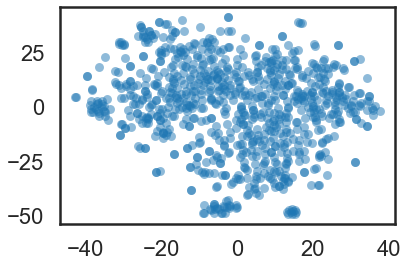

In [1661]:
plt.scatter(*tsne_projection.T, **plot_kwds)

# HDBSCAN Clustering

In [1662]:
import hdbscan

In [1669]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, prediction_data=True).fit(dataset['embedding'].values.tolist())

In [ ]:
clusterer.labels_

In [1236]:
n_clusters = clusterer.labels_.max

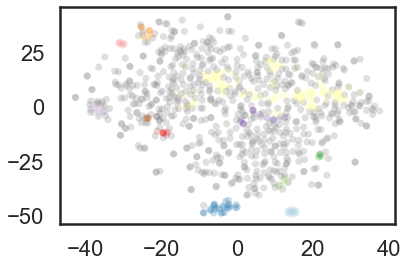

In [1671]:
color_palette = sns.color_palette('Paired', 24)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*tsne_projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

/Users/mahdi.rasouli/opt/anaconda3/lib/python3.8/site-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)


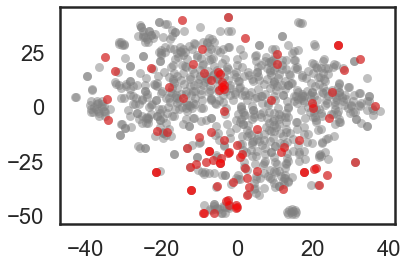

In [1672]:
#plotting detected outliers

threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*tsne_projection.T, c='gray', **plot_kwds)
plt.scatter(*tsne_projection[outliers].T, c='red', **plot_kwds)

In [1673]:
cluster_membership=pd.DataFrame(zip(clusterer.labels_, clusterer.probabilities_, clusterer.outlier_scores_))

In [1674]:
# plotting outlier scores
#sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

Testing new data points

In [1676]:
# just a test sample
test_data=[embeddings_clean[11]]

In [1677]:
#Predicting clusters for new points
test_labels, strengths = hdbscan.approximate_predict(clusterer, test_data)
test_labels

array([1])

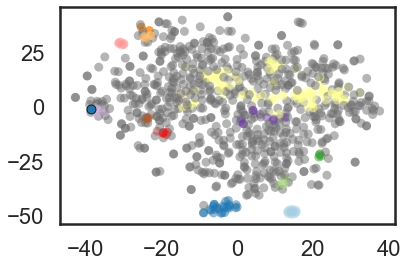

In [1678]:
#plotting new data
pal = sns.color_palette('Paired', 24)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
test_colors = [pal[col] if col >= 0 else (0.1, 0.1, 0.1) for col in test_labels]

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(*tsne_projection.T, c=colors, **plot_kwds);
plt.scatter(*tsne_projection[33].T, c=test_colors, s=80, linewidths=1, edgecolors='k')

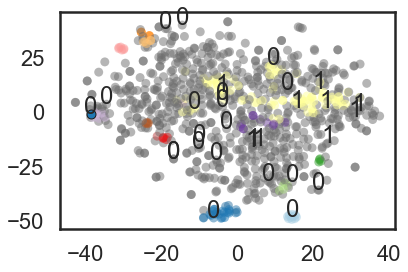

In [1679]:
#plotting labels
pal = sns.color_palette('Paired', 24)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
test_colors = [pal[col] if col >= 0 else (0.1, 0.1, 0.1) for col in test_labels]
plt.scatter(*tsne_projection.T, c=colors, **plot_kwds);
plt.scatter(*tsne_projection[33].T, c=test_colors, s=80, linewidths=1, edgecolors='k')

for i in range(30,60):

    label = "{:.0f}".format(dataset['complaint'][i])

    plt.annotate(label, # this is the text
                 tsne_projection[i], # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

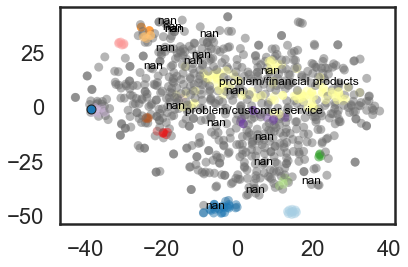

In [1680]:
#plotting labels
pal = sns.color_palette('Paired', 24)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
test_colors = [pal[col] if col >= 0 else (0.1, 0.1, 0.1) for col in test_labels]
plt.scatter(*tsne_projection.T, c=colors, **plot_kwds);
plt.scatter(*tsne_projection[33].T, c=test_colors, s=80, linewidths=1, edgecolors='k')

for i in range(10,30):

    label = "{}".format(dataset['topic'][i])

    plt.annotate(label, # this is the text
                 tsne_projection[i], # these are the coordinates to position the label
                 color='black',
                 size=12,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

Adjusting clusters

<AxesSubplot:ylabel='$\\lambda$ value'>

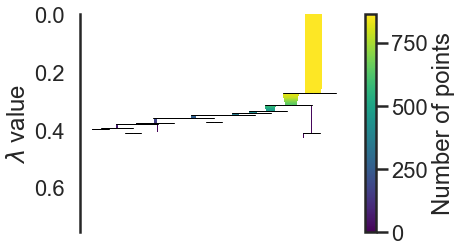

In [1246]:
clusterer.condensed_tree_.plot()

<AxesSubplot:ylabel='distance'>

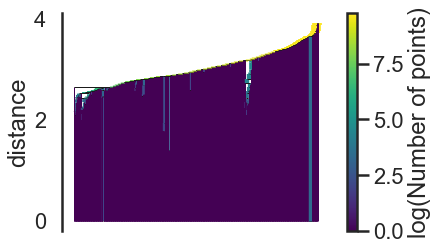

In [1247]:
clusterer.single_linkage_tree_.plot()

In [ ]:
clusterer.single_linkage_tree_.get_clusters(3, min_cluster_size=5)

# UMAP & HDBSCAN

Importing required libraries

In [814]:
!pip install umap-learn
#python -m pip install umap

You should consider upgrading via the '/Users/mahdi.rasouli/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [1078]:
#Dimension reduction and clustering libraries
import umap.umap_ as umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

Generating UMAP Projections

In [1716]:
# Define UMAP model to reduce embeddings dimension
umap_model = umap.UMAP(n_neighbors=10,
                       n_components=10,
                       min_dist=0,
                       metric='cosine',
                       low_memory=False,
                      )

In [1717]:
umap_embeddings=umap_model.fit_transform(dataset['embedding'].values.tolist())

Clusterin umap projections using hdbscan

In [1718]:
# Define HDBSCAN model to perform documents clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=2,
                                min_samples=10,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=True,
                               )

In [1719]:
hdbscan_cluster = hdbscan_model.fit(umap_embeddings)

In [1720]:
hdbscan_cluster.labels_

array([ 8,  1,  6,  6, -1, -1, 21, 21, 15, 14, -1,  0, -1,  8, -1, -1, -1,
       -1,  2,  2, 21, -1, 13, -1,  2, 14,  8, 10,  2,  2,  8,  8, -1,  1,
        2, 20, 15, 15,  2,  2,  2,  2,  1,  2, -1,  2, -1,  0, -1,  2,  2,
        6, -1, 13, 14, 16, 16, 11, -1, -1,  2, 11,  2,  2,  2, 16,  2, 20,
        2,  2, 14,  4, 14, 14, 14, 11, 18, -1, 19,  2, 16, -1, 16, 16, 18,
        2,  2, -1,  2,  2,  2,  2, -1,  2, 19, 11, 18, 21, -1, 21, 10,  2,
        8, 21, 13, -1, 21, 21,  2, 21, -1,  6,  2, -1,  5, 10,  8,  2, -1,
        8,  8, -1, -1,  2, -1, 10,  2,  4,  8,  1,  3, -1,  0,  2,  1, -1,
       15,  0, 14, -1,  3,  4, 10, -1, -1, -1, 14, -1, -1,  8,  2,  2,  2,
       -1, -1,  8,  8,  2,  8,  8, -1, 14,  8,  8,  8,  2,  6,  8, -1,  3,
        0,  2,  2,  2, -1,  2,  2,  2,  2,  0,  2, 20, 19,  2, -1, -1, 11,
       -1,  2, 18, -1, 19,  2, -1,  2, 16,  2, -1, -1,  2, 20, -1, 13,  2,
        2, -1, -1, 14,  2, -1,  2, 10, 10,  2,  8, 10, 10,  2,  2, -1, -1,
        2,  2, -1, 10,  2

In [1727]:
results=dataset

results['umap_projections']=list(umap_embeddings)
results['cluster']=hdbscan_cluster.labels_
results['cluster_probability']=hdbscan_cluster.probabilities_
results['outlier_score']=hdbscan_cluster.outlier_scores_

results.tail()


,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
857,2021-07-22 10:15:06,"Congrats to Ella Van De Velde Fidock, Register...",congrats to ella van de velde fidock registere...,0,NaN,"[-0.0061834496, 0.013299832, -0.013959851, 0.0...","[1.3509787, 6.2737646, 7.323146, 1.5259935, 6....",0,0.486376,0.513624
858,2021-07-22 23:39:22,@mebank How do you justify taking 3 weeks to g...,how do you justify taking week to generate an ...,1,problem/customer service,"[-0.044215076, 0.121117555, 0.0062509635, -0.1...","[-3.2982497, 13.235695, 9.644735, 1.5146056, 2...",-1,0.000000,0.020275
859,2021-07-23 13:21:12,@mebank So... do you have a timeframe when is ...,so do you have a timeframe when is prefill goi...,0,inquiry,"[-0.08879103, 0.23821402, -0.058278657, -0.006...","[-3.012704, 12.259639, 9.639155, 1.0011458, 2....",2,1.000000,0.177443
860,2021-07-24 01:09:02,So @mebank made me come all the way to police ...,so made me come all the way to police station ...,1,problem/others,"[-0.045577966, -0.12916017, 0.049081173, 0.106...","[-3.5209801, 12.728698, 9.794656, 1.6450081, 2...",21,0.883719,0.116281
861,2021-07-25 09:22:13,Making beautiful banking and helping Australi...,making beautiful banking and helping australia...,0,NaN,"[-0.12512365, -0.027903054, 0.0074063255, 0.04...","[-3.1394145, 12.208399, 9.78776, 2.233891, 2.3...",15,1.000000,0.000000


In [1728]:
#finding outliers
outliers=results.loc[results['cluster'].isin([-1])]
outliers.sample(5)

,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
113,2020-09-02 00:22:13,@TMFScottP @UBank @ING_Aust @BankofMelb @StGeo...,be careful with ubank disappointingly not offs...,0,NaN,"[-0.085779116, 0.092526644, -0.038209192, 0.03...","[-3.0293767, 12.276301, 9.628449, 2.8370786, 2...",-1,0.0,0.008182
721,2021-05-25 06:54:46,#westernaustralia trying to refinance my loan ...,trying to refinance my loan and poor desk valu...,0,NaN,"[-0.11438913, 0.123016395, 0.01869364, -0.1443...","[-3.2321172, 13.208419, 9.618833, 1.6062374, 2...",-1,0.0,0.106388
376,2021-01-12 07:03:15,Meant to settle on a property in 2 days but @m...,meant to settle on a property in day but haven...,1,problem/customer service,"[-0.042751376, 0.105113335, 0.02511361, 0.0567...","[-3.7786608, 13.281962, 9.65945, 1.3228142, 2....",-1,0.0,0.001203
843,2021-07-16 23:25:20,"@mebank Hi Kady, I called ME yesterday after u...",hi kady i called me yesterday after ur message...,1,problem/others,"[-0.05725454, -0.40347448, 0.010551008, -0.039...","[-3.1338122, 12.241871, 9.804654, 2.0791485, 2...",-1,0.0,0.065806
785,2021-06-17 07:00:25,"CBA has been up and down from 15:57pm, ANZ onl...",cba ha been up and down from 57pm anz online s...,1,problem/system down,"[-0.16330048, -0.32935852, -0.15326256, -0.093...","[-4.484948, 12.5576515, 9.679637, 2.1651762, 2...",-1,0.0,0.003323


In [1730]:
#clustered data
clustered = results.loc[~results['cluster'].isin([-1])]
clustered.sort_values(by='cluster')[400:450]


,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
102,2020-08-28 01:03:02,@mebank investing,investing,0,NaN,"[-0.07267013, 0.024540901, -0.025562087, 0.101...","[-3.1741116, 11.797004, 9.630681, 3.1334946, 2...",8,1.000000,0.075107
159,2020-10-01 23:53:50,@Heaton_Steven @TimWilsonMP @Vanguard_Group @I...,it strike me that tax avoidance is an imperati...,0,NaN,"[-0.08543647, -0.12774442, 0.16148727, 0.18626...","[-3.104351, 11.809502, 9.683917, 3.039754, 2.2...",8,1.000000,0.007124
116,2020-09-02 00:26:56,@au_shareplicity @UBank @ING_Aust @BankofMelb ...,bom and st george owned by westpac too for the...,0,NaN,"[-0.122375205, 0.06649063, 0.050487954, 0.0495...","[-3.7404718, 11.74504, 9.484114, 3.467355, 1.7...",8,1.000000,0.032801
158,2020-10-01 23:37:55,@TimWilsonMP @sweeneyged @Vanguard_Group @IFM_...,defending tiny tim is this the same business t...,0,NaN,"[0.03534802, 0.10662202, -0.0043639005, 0.2165...","[-3.0717485, 11.865432, 9.742291, 2.8547044, 2...",8,0.881886,0.118114
119,2020-09-02 00:30:43,@TMFScottP @UBank @ING_Aust @BankofMelb @StGeo...,but few others dont give the option even if me...,0,NaN,"[-0.027245829, 0.1700911, -0.0042222557, 0.076...","[-3.0014672, 11.977744, 9.672707, 2.9167538, 2...",8,0.815258,0.184742
120,2020-09-02 00:48:34,@financetrollau @UBank @ING_Aust @BankofMelb @...,yeah i think i agreethe option of converting i...,0,NaN,"[-0.043541595, 0.04449272, 0.0135957645, 0.084...","[-3.0533817, 11.914439, 9.663218, 2.9605334, 2...",8,0.936405,0.063595
156,2020-10-01 23:34:02,@TimWilsonMP @Vanguard_Group @IFM_Investors @u...,am i misunderstanding something here it entire...,0,NaN,"[-0.015977059, -0.087515704, 0.07154639, 0.232...","[-3.1478727, 11.787578, 9.653795, 3.1084528, 2...",8,1.000000,0.081557
155,2020-10-01 23:25:37,@sweeneyged @Vanguard_Group @IFM_Investors @un...,defending the 36m bonus or that can find 50000...,0,NaN,"[-0.009509591, -0.09993809, 0.0048480495, 0.26...","[-3.2226334, 11.793837, 9.688035, 3.0474384, 2...",8,1.000000,0.027092
128,2020-09-11 00:49:01,. @mebank has brought home the gold for Best S...,ha brought home the gold for best saving accou...,0,NaN,"[-0.109359585, -0.18963248, 0.050410572, 0.074...","[-3.921134, 12.506398, 9.3802805, 3.1062691, 2...",8,1.000000,0.329583
167,2020-10-03 13:49:29,@ElissaSursara @ANZ_AU @mebank I moved from co...,i moved from commbank last year to bank austra...,0,NaN,"[-0.102629274, -0.015675582, -0.02129364, -0.0...","[-3.9478219, 12.4306965, 9.31849, 3.114276, 2....",8,1.000000,0.154338


In [1731]:
#SAVING RESULTS
results.sort_values(by='date')
results.to_csv('../data/results_sorted_by_date.csv', index=False)
results.to_csv(f"{s3_data_dir}/results/mebank_tweets_clusters_sorted_by_date.csv",index=False)

In [1732]:
#SAVING RESULTS
results_cluster_sorted=results.sort_values(by='cluster')
results_cluster_sorted.to_csv('../data/results_sorted_by_cluster.csv', index=False)
results_cluster_sorted.to_csv(f"{s3_data_dir}/results/mebank_tweets_clusters_sorted_by_cluster.csv",index=False)


VISUALIZATION


In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))

#threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
#outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
#outliers = np.where(hdbscan_cluster.labels_ == -1)
#outliers = results.loc[results.cluster == -1, :]
plt.scatter(outliers['umap_projections'][:,0], outliers['umap_projections'][:,1], color='#BDBDBD', s=0.05)
plt.scatter(clustered['umap_projections'][:,0], clustered['umap_projections'][:,1], c=clustered['cluster'], s=0.5, cmap='hsv_r')
plt.colorbar()

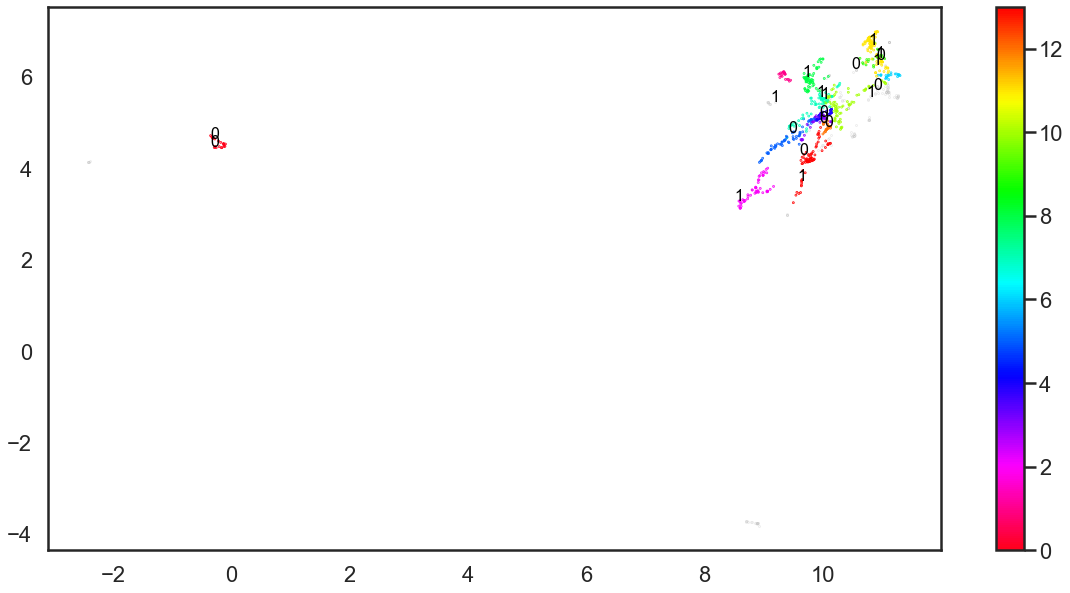

In [584]:
# Visualize cluster and labels 
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.5, cmap='hsv_r')
plt.colorbar()


#plotting labels
for i in range(10,30):

    label = "{:.0f}".format(dataset['complaint'][i])

    plt.annotate(label, # this is the text
                 (result['x'][i],result['y'][i]), # these are the coordinates to position the label
                 color='black',
                 size=16,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

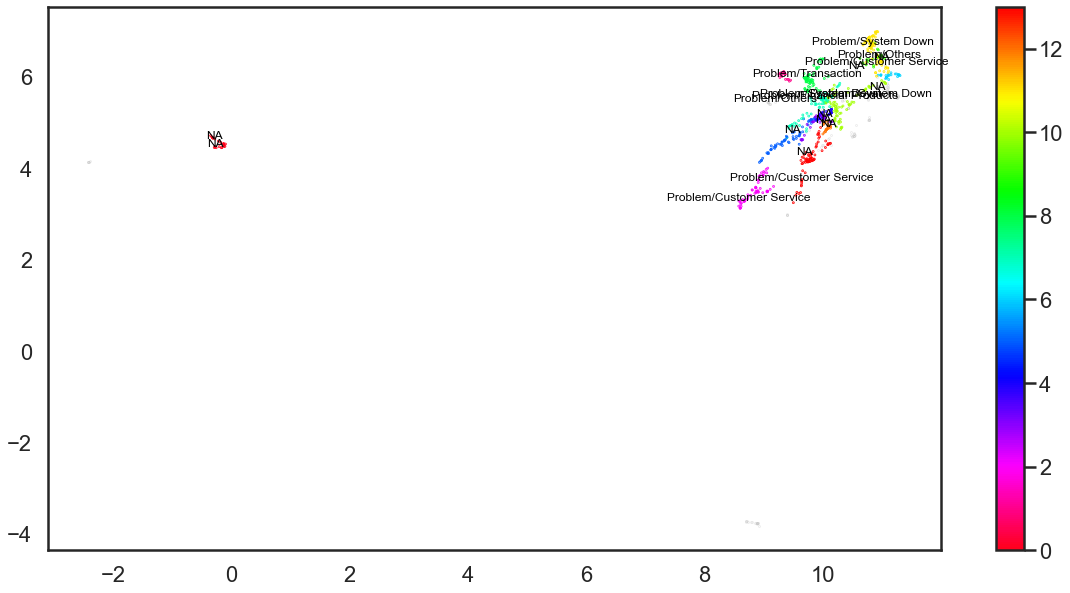

In [585]:
# Visualize cluster and labels 
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.5, cmap='hsv_r')
plt.colorbar()


#plotting labels
for i in range(10,30):

    label = "{}".format(dataset['topic'][i])

    plt.annotate(label, # this is the text
                 (result['x'][i],result['y'][i]), # these are the coordinates to position the label
                 color='black',
                 size=12,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

# Quantitative Model Evaluation

In [586]:
#from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

#adjusted_rand_score(dataset['topic'], result['labels']), adjusted_mutual_info_score(dataset['topic'], result['labels'])

(0.031164243259547558, 0.20168266687017464)

# Topic Modelling

In [1733]:
results.sample()

,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
88,2020-08-27 01:44:15,@mebank Nope. Still out 11.10am CST.,nope still out am cst,0,NaN,"[-0.1680683, -0.3978843, -0.038387775, 0.00433...","[-2.7538624, 12.014423, 9.657179, 0.8404104, 2...",2,1.0,0.086721


In [1742]:
docs_df= pd.DataFrame()
docs_df['Doc']=results['content']
docs_df['Doc_Clean']=results['content_clean']
docs_df['Topic'] = results['cluster']
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic_raw = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
docs_per_topic_clean = docs_df.groupby(['Topic'], as_index = False).agg({'Doc_Clean': ' '.join})
docs_per_topic=pd.merge(docs_per_topic_raw, docs_per_topic_clean, on=["Topic"])

In [1743]:
docs_per_topic.head()

,Topic,Doc,Doc_Clean
0,-1,Well done to @mebank for adding #Braille on my...,well done to for adding on my new bank card th...
1,0,Nominate an organisation or team in the aged c...,nominate an organisation or team in the aged c...
2,1,@scott_bray4128 @slpng_giants_oz @ING_Aust Agr...,agree take your money out of ing peep and look...
3,2,@hayderaly98 @CommBank @StGeorgeBank @BankSA @...,glass half full yes thats a great deal in the ...
4,3,mebank continues to be the absolute worst http...,mebank continues to be the absolute worst can ...


In [1744]:
clustering_results=docs_per_topic

In [1745]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 2)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(dataset))

In [1766]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)
topic_sizes = extract_topic_sizes(docs_df)

In [1767]:
np.array(top_n_words[-1])[:,0]
str(list(np.array(top_n_words[-1])[:,0]))

"['loan', 'https', 'banking', 'amp', 'account', 'bank', 'banks', 'rates', 'customers', 'home loan']"

In [1768]:
clustering_results['cluster_size']=topic_sizes['Size']

for i,topic in enumerate(clustering_results['Topic']):
	clustering_results.loc[i,'top_words']=str(list(np.array(top_n_words[topic])[:,0]))

clustering_results

,Topic,Doc,Doc_Clean,cluster_size,top_words,summary
0,-1,Well done to @mebank for adding #Braille on my...,well done to for adding on my new bank card th...,205,"['loan', 'https', 'banking', 'amp', 'account',...",Well done to @mebank for adding #Braille on my...
1,0,Nominate an organisation or team in the aged c...,nominate an organisation or team in the aged c...,26,"['awards', '000', '2021', 'nominate', 'hesta',...",Nominate an organisation or team in the aged c...
2,1,@scott_bray4128 @slpng_giants_oz @ING_Aust Agr...,agree take your money out of ing peep and look...,33,"['fossil', 'fuels', 'fossil fuels', 'boq', 'fo...",Take your money out of ING peeps and look for...
3,2,@hayderaly98 @CommBank @StGeorgeBank @BankSA @...,glass half full yes thats a great deal in the ...,222,"['thanks', 'hold', 'äôs', 'customer', 'phone',...",@hayderaly98 @CommBank @StGeorgeBank @BankSA @...
4,3,mebank continues to be the absolute worst http...,mebank continues to be the absolute worst can ...,13,"['drcraigemerson', 'mebank drcraigemerson', 'b...",co/ennvbqppnb @mebank can i install mebank app...
5,4,.@MEbank launches @GooglePay as demand for #di...,launch a demand for increase i am paying more ...,20,"['property', 'https', 'realestate', 'home buye...",@MEbank launches @GooglePay as demand for #dig...
6,5,@TMFScottP @UBank @ING_Aust @BankofMelb @StGeo...,ubank is nab bank of israel gt new startup ban...,3,"['ubank', 'nbn', 'banks', 'gt new', 'startup b...",@TMFScottP @UBank @ING_Aust @BankofMelb @StGeo...
7,6,"According to new research by @mebank, the #Cov...",according to new research by the pandemic ha g...,10,"['üí', 'data', 'outlook', 'aussies', 'research...","According to new research by @mebank, the #Cov..."
8,7,"@mebank Hi Kady, already called the bank: they...",hi kady already called the bank they confirmed...,4,"['different', 'login', 'different business', '...","@mebank Hi Kady, already called the bank: they..."
9,8,@BroHilderchump I would recommend Mebank (owne...,i would recommend mebank owned by industry sup...,112,"['bank', 'boq', 'bank queensland', 'queensland...",@BroHilderchump I would recommend Mebank (owne...


In [ ]:
# if using gensim for cluster summary
!pip install gensim==3.8.3

In [ ]:
# if using pysummarization for cluster summary
!pip install pysummarization

In [1770]:
#from gensim.summarization.summarizer import summarize as gensim_summarize	
from pysummarization.nlpbase.auto_abstractor import AutoAbstractor
from pysummarization.tokenizabledoc.simple_tokenizer import SimpleTokenizer
from pysummarization.abstractabledoc.top_n_rank_abstractor import TopNRankAbstractor
from operator import itemgetter


def get_summary(text):
	
	#using gensim -> depreciated: did not work properly, suggested to use version 3.4 or less
	#text_summary=summarize(text, ratio=0.2, word_count=None, split=False)

	#using pysummerization library
	# Object of automatic summarization.
	auto_abstractor = AutoAbstractor()
	# Set tokenizer.
	auto_abstractor.tokenizable_doc = SimpleTokenizer()
	# Set delimiter for making a list of sentence.
	auto_abstractor.delimiter_list = [".", "\n"]
	# Object of abstracting and filtering document.
	abstractable_doc = TopNRankAbstractor()

	# Summarize document.
	result_dict = auto_abstractor.summarize(text, abstractable_doc)
	
	# Extracting the highest score sentence
	max_index=max(result_dict['scoring_data'],key=itemgetter(1))[0]
	max_sen=result_dict['summarize_result'][max_index]

	return max_sen

In [1771]:
# there is an issue with length of bigger length of Doc, works for Doc_Clean
for i,doc in enumerate(clustering_results['Doc']):
	clustering_results.loc[i,'summary']=get_summary(doc[:150])


clustering_results.sample()

,Topic,Doc,Doc_Clean,cluster_size,top_words,summary
15,14,"@mebank Hi, with your internet banking, for Pa...",hi with your internet banking for pay anyone i...,16,"['pay', 'payid', 'google pay', 'google', 'paym...","@mebank Hi, with your internet banking, for Pa..."


In [1821]:
results_cluster_sorted.sample()

,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
68,2020-08-24 10:19:24,@mebank Oh yes. Just that it‚Äôs down again üò©,oh yes just that it down again,1,problem/system down,"[-0.03926274, 0.08011028, -0.16186309, -0.0890...","[-2.0271, 11.232707, 9.529115, 0.88551384, 3.4...",2,1.0,0.244757


In [1856]:
results_cluster_sorted[results_cluster_sorted['cluster'].isin([8]) & results_cluster_sorted['cluster_probability'].isin([1.0])]

,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
639,2021-04-13 23:22:45,@asintemple @HutchHussein @mebank @bankaust I ...,i didnt realise this meant that isf were no lo...,0,NaN,"[-0.02077405, -0.25972882, 0.013749002, 0.1121...","[-3.2680984, 11.739396, 9.621786, 3.1661842, 2...",8,1.0,0.056780
633,2021-04-13 08:53:15,Looking to change banks - tossing up btwn @meb...,looking to change bank tossing up btwn amp any...,0,NaN,"[-0.11388483, -0.25947446, 0.03188971, 0.00102...","[-3.8881245, 12.323594, 9.426871, 3.1214843, 2...",8,1.0,0.232762
636,2021-04-13 12:29:52,@HutchHussein @mebank @bankaust I had a really...,i had a really positive experience with bank a...,0,NaN,"[-0.05933569, 0.027011942, -0.051569164, -0.09...","[-3.9469295, 12.374255, 9.311845, 3.2272623, 2...",8,1.0,0.000000
635,2021-04-13 11:32:10,@HutchHussein @mebank @bankaust Made a similar...,made a similar call to switch away from a big ...,0,NaN,"[-0.023326185, -0.20760521, -0.06666887, -0.08...","[-3.937206, 12.35192, 9.34424, 3.2198477, 2.18...",8,1.0,0.218114
855,2021-07-22 05:01:02,@EllisonAmy @mebank I switched to @bankaust ab...,i switched to about month ago and have been ha...,0,NaN,"[-0.06607365, -0.10989715, 0.03235361, -0.2265...","[-3.8157687, 12.259271, 9.297264, 3.1112754, 2...",8,1.0,0.391932
...,...,...,...,...,...,...,...,...,...,...
483,2021-02-22 02:56:40,@mebank Hi ME - thanks for your reply and info...,hi me thanks for your reply and info i am keen...,0,NaN,"[-0.00998595, -0.28847894, -2.5749505e-05, 0.0...","[-3.7064242, 12.087113, 9.508515, 3.1139915, 2...",8,1.0,0.063363
530,2021-02-23 23:09:59,So #MeBank is merging with Bank of Queensland ...,so is merging with bank of queensland boq inte...,0,NaN,"[-0.007926402, -0.012729903, -0.053838138, -0....","[-3.7319336, 11.646441, 9.475423, 3.5545835, 1...",8,1.0,0.000000
531,2021-02-23 23:09:59,So #MeBank is merging with Bank of Queensland ...,so is merging with bank of queensland boq inte...,0,NaN,"[-0.007926402, -0.012729903, -0.053838138, -0....","[-3.770252, 11.656907, 9.478283, 3.5543127, 1....",8,1.0,0.000000
532,2021-02-23 23:32:28,So after lying to me when I asked direct quest...,so after lying to me when i asked direct quest...,1,others,"[0.03637239, 0.061306555, 0.012942265, 0.11441...","[-3.4591594, 11.802378, 9.633353, 3.02324, 1.9...",8,1.0,0.054457


In [1819]:
for i,topic in enumerate(clustering_results['Topic']):
	print(i)
	print(topic)
	best_tweet=results_cluster_sorted.loc[results_cluster_sorted['cluster']==topic,:]
	#print(best_tweet)
	#clustering_results.loc[i,'best_tweet']=get_summary(doc[:150])


#clustering_results.sample()




0
-1
1
0
2
1
3
2
4
3
5
4
6
5
7
6
8
7
9
8
10
9
11
10
12
11
13
12
14
13
15
14
16
15
17
16
18
17
19
18
20
19
21
20
22
21


BERTopic

In [ ]:
# Create BERTopic model
topic_model = BERTopic(top_n_words=10,
                       n_gram_range=(1,2), 
                       calculate_probabilities=True,
                       umap_model= umap_model,
                       hdbscan_model=hdbscan_model,
                       similarity_threshold_merging=0.5,
                       verbose=True)

# Train model, extract topics and probabilities
topics, probabilities = topic_model.fit_transform(docs, embeddings)